# ai4 for health related matters

## dependencies

In [34]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

## dataset stuff

### read the dataset

In [35]:
df = pd.read_csv('dataset.csv')
df = df.sample(frac = 1)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
47,50,1,4,150,243,0,2,128,0,2.6,2,0.0,7.0,4
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
191,51,1,4,140,298,0,0,122,1,4.2,2,3.0,7.0,3
293,63,1,4,140,187,0,2,144,1,4.0,1,2.0,7.0,2
22,58,1,2,120,284,0,2,160,0,1.8,2,0.0,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,51,1,4,140,261,0,2,186,1,0.0,1,0.0,3.0,0
194,68,0,3,120,211,0,2,115,0,1.5,2,0.0,3.0,0
151,42,0,4,102,265,0,2,122,0,0.6,2,0.0,3.0,0
96,59,1,4,110,239,0,2,142,1,1.2,2,1.0,7.0,2


### train_test split

In [36]:
ratio = 0.95 # 90:10 train:test ratio
train_set = df.sample(frac=ratio)

# Dropping all those indexes from the dataframe that exists in the train_set
test_set = df.drop(train_set.index)
train_set.shape, test_set.shape

train_set
test_set

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
66,60,1,3,140,185,0,2,155,0,3.0,2,0.0,3.0,1
256,67,0,4,106,223,0,0,142,0,0.3,1,2.0,3.0,0
8,63,1,4,130,254,0,2,147,0,1.4,2,1.0,7.0,2
250,57,1,4,110,201,0,0,126,1,1.5,2,0.0,6.0,0
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
193,62,0,4,138,294,1,0,106,0,1.9,2,3.0,3.0,2
296,59,1,4,164,176,1,2,90,0,1.0,2,2.0,6.0,3
262,60,0,1,150,240,0,0,171,0,0.9,1,0.0,3.0,0
234,54,0,3,160,201,0,0,163,0,0.0,1,1.0,3.0,0
77,51,0,3,140,308,0,2,142,0,1.5,1,1.0,3.0,0


### formating

In [37]:
# import training dataset

# Clean column names
train_set.columns = train_set.columns.str.strip()

# Handle missing values represented by '?'
train_set = train_set.replace('?', np.nan)

# Convert columns to numeric, drop rows with NaNs
train_set = train_set.dropna()
train_set = train_set.astype(float)

# Split features and labels
X = train_set.drop("diagnosis", axis=1)
y = train_set["diagnosis"]

y = (y > 0.5).astype(float)  # Ensures only 0 or 1

# normalise featuress from minmax scaling (sklearn)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors
inputs = torch.tensor(X_scaled, dtype=torch.float32)
targets = torch.tensor(y.values, dtype=torch.float32)

print(inputs.shape, targets.shape)

torch.Size([282, 13]) torch.Size([282])


In [38]:
# import training dataset

# Clean column names
test_set.columns = test_set.columns.str.strip()

# Handle missing values represented by '?'
test_set = test_set.replace('?', np.nan)

# Convert columns to numeric, drop rows with NaNs
test_set = test_set.dropna()
test_set = test_set.astype(float)

# Split features and labels
X = test_set.drop("diagnosis", axis=1)
y = test_set["diagnosis"]

y = (y > 0.5).astype(float)  # Ensures only 0 or 1

# normalise featuress from minmax scaling (sklearn)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors
test_inputs = torch.tensor(X_scaled, dtype=torch.float32)
test_targets = torch.tensor(y.values, dtype=torch.float32)

print(test_inputs.shape, test_targets.shape)

torch.Size([15, 13]) torch.Size([15])


## AI1

### setup/params

In [39]:
class SimpleNN(nn.Module): 
    def __init__(self): 
        super(SimpleNN, self).__init__() 
        self.fc1 = nn.Linear(13, 26)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(26, 1)
        
    def forward(self, x): 
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x  # No sigmoid here; use BCEWithLogitsLoss

model = SimpleNN()
print(model)

SimpleNN(
  (fc1): Linear(in_features=13, out_features=26, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=26, out_features=1, bias=True)
)


### error calcs.

In [40]:
#calculate error
# Use BCEWithLogitsLoss for binary classification
criterion = nn.BCEWithLogitsLoss()
optimiser = optim.SGD(model.parameters(), lr=0.01)

# Ensure targets are shape (N, 1)
targets = targets.view(-1, 1)
print(targets)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
      

### training

In [41]:
# learning rate and epochs
epochs = 10000
lr = 0.005

Epoch [1/10000], Loss: 0.6889
Epoch [2/10000], Loss: 0.6886
Epoch [3/10000], Loss: 0.6882
Epoch [4/10000], Loss: 0.6879
Epoch [5/10000], Loss: 0.6875
Epoch [6/10000], Loss: 0.6872
Epoch [7/10000], Loss: 0.6869
Epoch [8/10000], Loss: 0.6866
Epoch [9/10000], Loss: 0.6862
Epoch [10/10000], Loss: 0.6859
Epoch [11/10000], Loss: 0.6856
Epoch [12/10000], Loss: 0.6853
Epoch [13/10000], Loss: 0.6849
Epoch [14/10000], Loss: 0.6846
Epoch [15/10000], Loss: 0.6843
Epoch [16/10000], Loss: 0.6840
Epoch [17/10000], Loss: 0.6837
Epoch [18/10000], Loss: 0.6834
Epoch [19/10000], Loss: 0.6831
Epoch [20/10000], Loss: 0.6828
Epoch [21/10000], Loss: 0.6825
Epoch [22/10000], Loss: 0.6822
Epoch [23/10000], Loss: 0.6819
Epoch [24/10000], Loss: 0.6816
Epoch [25/10000], Loss: 0.6813
Epoch [26/10000], Loss: 0.6810
Epoch [27/10000], Loss: 0.6807
Epoch [28/10000], Loss: 0.6804
Epoch [29/10000], Loss: 0.6801
Epoch [30/10000], Loss: 0.6798
Epoch [31/10000], Loss: 0.6795
Epoch [32/10000], Loss: 0.6792
Epoch [33/10000],

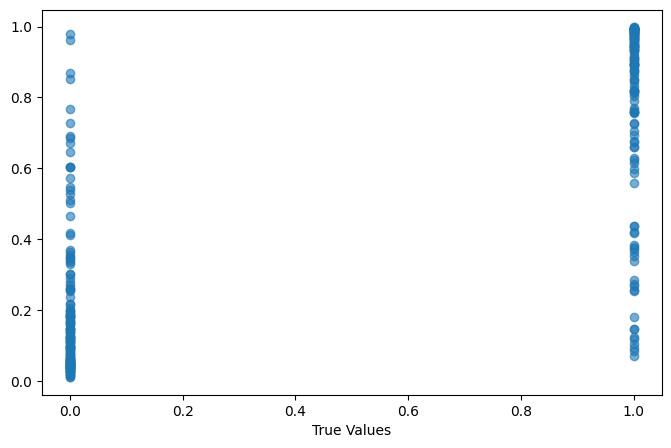

In [42]:
for epoch in range(epochs):
    optimiser.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    if torch.isnan(loss):
        print("Loss is NaN!")
        break
    loss.backward()
    optimiser.step()
#    if (epoch + 1) % 500 == 0:
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
print(outputs)

# Evaluate on training set
with torch.no_grad():
    outputs = model(inputs)
    preds = torch.sigmoid(outputs)
    predicted_classes = (preds > 0.5).float()
    accuracy1 = (predicted_classes == targets).float().mean()
    print(f"Training Accuracy: {accuracy1.item()*100:.2f}%")

    # Plot predictions vs. true values
    plt.figure(figsize=(8, 5))
    plt.scatter(targets.numpy(), preds.numpy(), alpha=0.6)
    plt.xlabel("True Values")

### testing

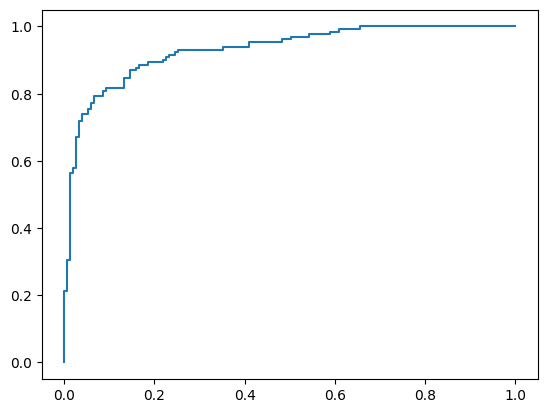

In [43]:
# roc curve
fpr1, tpr1, _ = roc_curve(targets.numpy(), preds.numpy())
plt.plot(fpr1, tpr1, label = "ROC Curve")

tensor(0.4000)
Training Accuracy: 52.00%


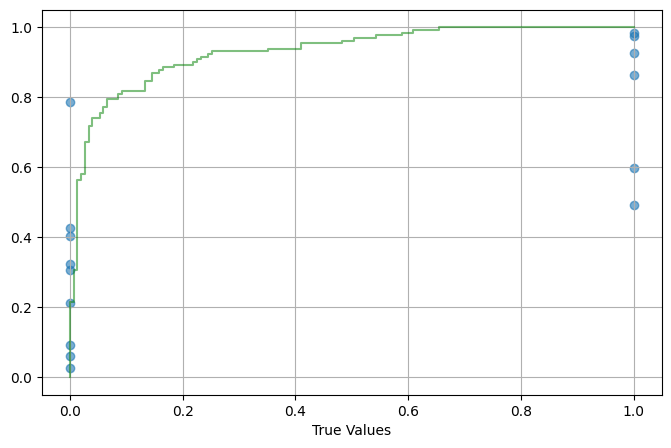

In [44]:
test = torch.sigmoid(model(test_inputs))
accuracy_test = (test > 0.5).float().mean()
print(accuracy_test)

with torch.no_grad():
    test_outputs1 = model(test_inputs)
    test_preds = torch.sigmoid(test_outputs1)
    predicted_classes = (test_preds > 0.5).float()
    test_accuracy1 = (predicted_classes == test_targets).float().mean()
    print(f"Training Accuracy: {test_accuracy1.item()*100:.2f}%")

    # Plot predictions vs. true values
    plt.figure(figsize=(8, 5))
    plt.scatter(test_targets.numpy(), test_preds.numpy(), alpha=0.6)
    plt.xlabel("True Values")

# roc curve
test_fpr1, test_tpr1, _ = roc_curve(targets.numpy(), preds.numpy())
plt.plot(test_fpr1, test_tpr1, label = "ROC Curve", color = "green", alpha=0.5)
plt.grid(True)

## AI2

### setup/params.

In [45]:
class SimpleNN(nn.Module): 
    def __init__(self): 
        super(SimpleNN, self).__init__() 
        self.fc1 = nn.Linear(13, 26)
        self.celu = nn.CELU()
        self.fc2 = nn.Linear(26, 32)
        self.rrelu2 = nn.RReLU()
        self.fc3 = nn.Linear(32, 100)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(100, 64)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(64, 1) #output layer
        
    def forward(self, x): 
        x = self.fc1(x)
        x = self.celu(x)
        x = self.fc2(x)
        x = self.rrelu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)
        return x  # No sigmoid here; use BCEWithLogitsLoss

model = SimpleNN()
model

SimpleNN(
  (fc1): Linear(in_features=13, out_features=26, bias=True)
  (celu): CELU(alpha=1.0)
  (fc2): Linear(in_features=26, out_features=32, bias=True)
  (rrelu2): RReLU(lower=0.125, upper=0.3333333333333333)
  (fc3): Linear(in_features=32, out_features=100, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=100, out_features=64, bias=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=64, out_features=1, bias=True)
)

### error calcs.

In [46]:
#calculate error
# Use BCEWithLogitsLoss for binary classification
criterion = nn.BCEWithLogitsLoss()
optimiser = optim.SGD(model.parameters(), lr=0.01)

# Ensure targets are shape (N, 1)
targets = targets.view(-1, 1)
print(targets)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
      

### training

In [47]:
# learning rate and epochs (variables)
epochs = 30000
lr = 0.05

Epoch [1/30000], Loss: 0.6972
Epoch [2/30000], Loss: 0.6973
Epoch [3/30000], Loss: 0.6972
Epoch [4/30000], Loss: 0.6971
Epoch [5/30000], Loss: 0.6971
Epoch [6/30000], Loss: 0.6970
Epoch [7/30000], Loss: 0.6970
Epoch [8/30000], Loss: 0.6969
Epoch [9/30000], Loss: 0.6969
Epoch [10/30000], Loss: 0.6969
Epoch [11/30000], Loss: 0.6968
Epoch [12/30000], Loss: 0.6967
Epoch [13/30000], Loss: 0.6966
Epoch [14/30000], Loss: 0.6966
Epoch [15/30000], Loss: 0.6965
Epoch [16/30000], Loss: 0.6965
Epoch [17/30000], Loss: 0.6964
Epoch [18/30000], Loss: 0.6965
Epoch [19/30000], Loss: 0.6964
Epoch [20/30000], Loss: 0.6963
Epoch [21/30000], Loss: 0.6962
Epoch [22/30000], Loss: 0.6963
Epoch [23/30000], Loss: 0.6962
Epoch [24/30000], Loss: 0.6961
Epoch [25/30000], Loss: 0.6961
Epoch [26/30000], Loss: 0.6961
Epoch [27/30000], Loss: 0.6960


Epoch [28/30000], Loss: 0.6959
Epoch [29/30000], Loss: 0.6959
Epoch [30/30000], Loss: 0.6958
Epoch [31/30000], Loss: 0.6958
Epoch [32/30000], Loss: 0.6958
Epoch [33/30000], Loss: 0.6957
Epoch [34/30000], Loss: 0.6956
Epoch [35/30000], Loss: 0.6956
Epoch [36/30000], Loss: 0.6955
Epoch [37/30000], Loss: 0.6956
Epoch [38/30000], Loss: 0.6955
Epoch [39/30000], Loss: 0.6954
Epoch [40/30000], Loss: 0.6954
Epoch [41/30000], Loss: 0.6954
Epoch [42/30000], Loss: 0.6953
Epoch [43/30000], Loss: 0.6953
Epoch [44/30000], Loss: 0.6952
Epoch [45/30000], Loss: 0.6952
Epoch [46/30000], Loss: 0.6951
Epoch [47/30000], Loss: 0.6951
Epoch [48/30000], Loss: 0.6950
Epoch [49/30000], Loss: 0.6950
Epoch [50/30000], Loss: 0.6950
Epoch [51/30000], Loss: 0.6949
Epoch [52/30000], Loss: 0.6949
Epoch [53/30000], Loss: 0.6949
Epoch [54/30000], Loss: 0.6948
Epoch [55/30000], Loss: 0.6948
Epoch [56/30000], Loss: 0.6947
Epoch [57/30000], Loss: 0.6947
Epoch [58/30000], Loss: 0.6947
Epoch [59/30000], Loss: 0.6946
Epoch [6

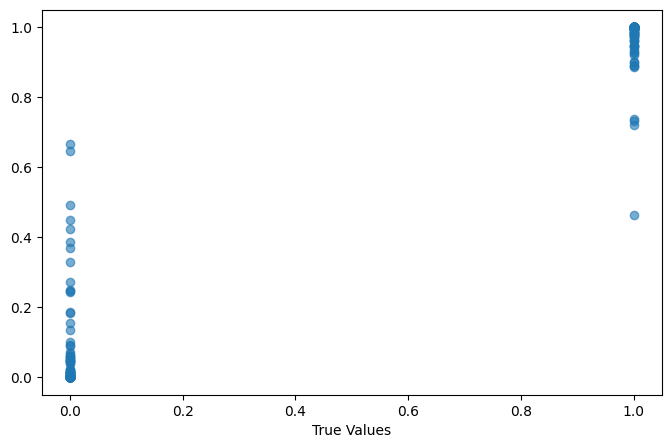

In [48]:
for epoch in range(epochs):
    optimiser.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    if torch.isnan(loss):
        print("Loss is NaN!")
        break
    loss.backward()
    optimiser.step()
#    if (epoch + 1) % 500 == 0:
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
print(outputs)

# Evaluate on training set
with torch.no_grad():
    outputs = model(inputs)
    preds = torch.sigmoid(outputs)
    predicted_classes = (preds > 0.5).float()
    accuracy2 = (predicted_classes == targets).float().mean()
    print(f"Training Accuracy: {accuracy2.item()*100:.2f}%")

    # Plot predictions vs. true values
    plt.figure(figsize=(8, 5))
    plt.scatter(targets.numpy(), preds.numpy(), alpha=0.6)
    plt.xlabel("True Values")

### testing

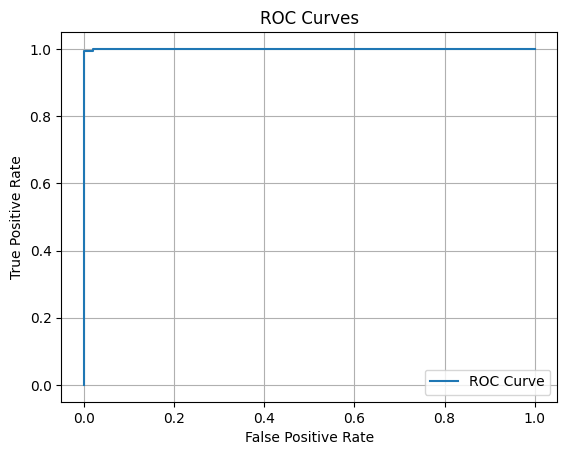

In [49]:
# roc curve
fpr2, tpr2, _ = roc_curve(targets.numpy(), preds.numpy())
plt.plot(fpr2, tpr2, label = "ROC Curve")
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

tensor(0.4000)
Training Accuracy: 52.00%


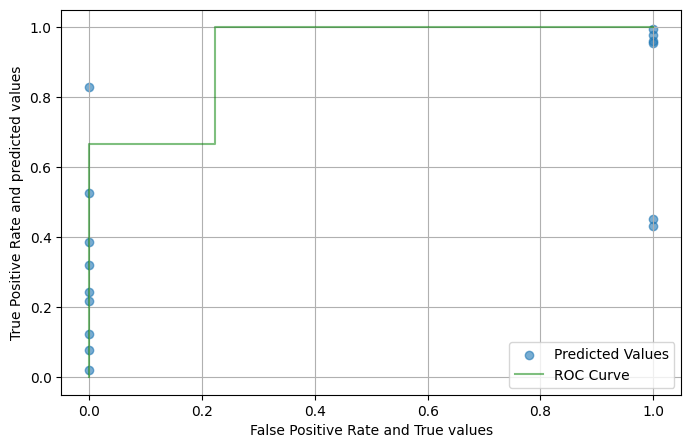

In [60]:
test = torch.sigmoid(model(test_inputs))
accuracy_test = (test > 0.5).float().mean()
print(accuracy_test)

with torch.no_grad():
    test_outputs2 = model(test_inputs)
    test_preds = torch.sigmoid(test_outputs2)
    predicted_classes = (test_preds > 0.5).float()
    test_accuracy2 = (predicted_classes == test_targets).float().mean()
    print(f"Training Accuracy: {test_accuracy2.item()*100:.2f}%")

    # Plot predictions vs. true values
    plt.figure(figsize=(8, 5))
    plt.scatter(test_targets.numpy(), test_preds.numpy(), alpha=0.6, label="Predicted Values")

# roc curve
test_fpr2, test_tpr2, _ = roc_curve(test_targets.numpy(), test_preds.numpy())
plt.plot(test_fpr2, test_tpr2, label = "ROC Curve", color = "green", alpha=0.5)
plt.legend()
plt.xlabel("False Positive Rate and True values")
plt.ylabel("True Positive Rate and predicted values")
plt.grid(True)

## AI3

### setup/params

In [61]:
class SimpleNN(nn.Module): 
    def __init__(self): 
        super(SimpleNN, self).__init__() 
        self.fc1 = nn.Linear(13, 26)
        self.rrelu = nn.RReLU()
        self.fc2 = nn.Linear(26, 26)
        self.silu2 = nn.SiLU()
        self.fc3 = nn.Linear(26, 1)


    def forward(self, x): 
        x = self.fc1(x)
        x = self.rrelu(x)
        x = self.fc2(x)
        x = self.silu2(x)
        x = self.fc3(x)
        return x  # No sigmoid here; use BCEWithLogitsLoss

model = SimpleNN()
print(model)

SimpleNN(
  (fc1): Linear(in_features=13, out_features=26, bias=True)
  (rrelu): RReLU(lower=0.125, upper=0.3333333333333333)
  (fc2): Linear(in_features=26, out_features=26, bias=True)
  (silu2): SiLU()
  (fc3): Linear(in_features=26, out_features=1, bias=True)
)


### error calcs.

In [62]:
#calculate error
# Use BCEWithLogitsLoss for binary classification
criterion = nn.BCEWithLogitsLoss()
optimiser = optim.SGD(model.parameters(), lr=0.01)

# Ensure targets are shape (N, 1)
targets = targets.view(-1, 1)
print(targets)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
      

### training

In [63]:
# learning rate and epochs
epochs = 10000
lr = 0.005

Epoch [1/10000], Loss: 0.6963
Epoch [2/10000], Loss: 0.6960
Epoch [3/10000], Loss: 0.6961
Epoch [4/10000], Loss: 0.6962
Epoch [5/10000], Loss: 0.6960


Epoch [6/10000], Loss: 0.6962
Epoch [7/10000], Loss: 0.6962
Epoch [8/10000], Loss: 0.6962
Epoch [9/10000], Loss: 0.6962
Epoch [10/10000], Loss: 0.6960
Epoch [11/10000], Loss: 0.6960
Epoch [12/10000], Loss: 0.6959
Epoch [13/10000], Loss: 0.6959
Epoch [14/10000], Loss: 0.6959
Epoch [15/10000], Loss: 0.6959
Epoch [16/10000], Loss: 0.6959
Epoch [17/10000], Loss: 0.6959
Epoch [18/10000], Loss: 0.6958
Epoch [19/10000], Loss: 0.6960
Epoch [20/10000], Loss: 0.6959
Epoch [21/10000], Loss: 0.6957
Epoch [22/10000], Loss: 0.6958
Epoch [23/10000], Loss: 0.6956
Epoch [24/10000], Loss: 0.6957
Epoch [25/10000], Loss: 0.6957
Epoch [26/10000], Loss: 0.6956
Epoch [27/10000], Loss: 0.6955
Epoch [28/10000], Loss: 0.6956
Epoch [29/10000], Loss: 0.6955
Epoch [30/10000], Loss: 0.6955
Epoch [31/10000], Loss: 0.6955
Epoch [32/10000], Loss: 0.6955
Epoch [33/10000], Loss: 0.6954
Epoch [34/10000], Loss: 0.6955
Epoch [35/10000], Loss: 0.6953
Epoch [36/10000], Loss: 0.6954
Epoch [37/10000], Loss: 0.6954
Epoch [38/10

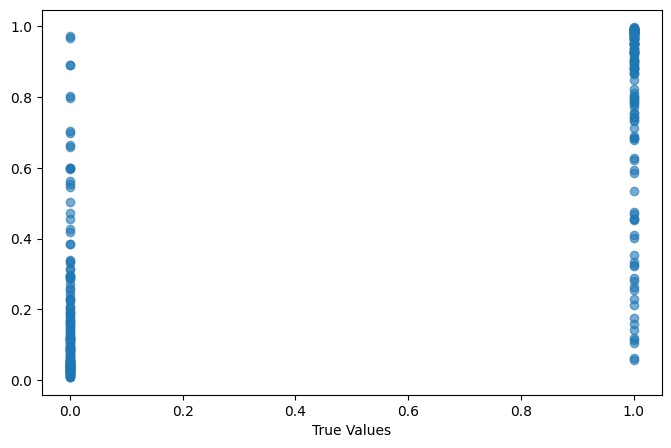

In [64]:
for epoch in range(epochs):
    optimiser.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    if torch.isnan(loss):
        print("Loss is NaN!")
        break
    loss.backward()
    optimiser.step()
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
print(outputs)

# Evaluate on training set
with torch.no_grad():
    outputs = model(inputs)
    preds = torch.sigmoid(outputs)
    predicted_classes = (preds > 0.5).float()
    accuracy3 = (predicted_classes == targets).float().mean()
    print(f"Training Accuracy: {accuracy3.item()*100:.2f}%")

    # Plot predictions vs. true values
    plt.figure(figsize=(8, 5))
    plt.scatter(targets.numpy(), preds.numpy(), alpha=0.6)
    plt.xlabel("True Values")

### testing

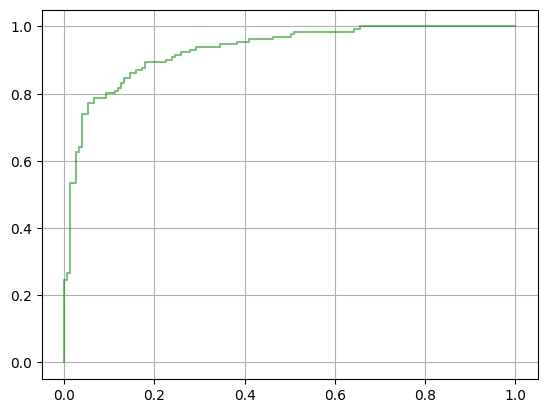

In [65]:
# roc curve
fpr3, tpr3, _ = roc_curve(targets.numpy(), preds.numpy())
plt.plot(fpr3, tpr3, label = "ROC Curve", color = "green", alpha=0.5)
plt.grid(True)

tensor(0.4667)
Training Accuracy: 50.67%


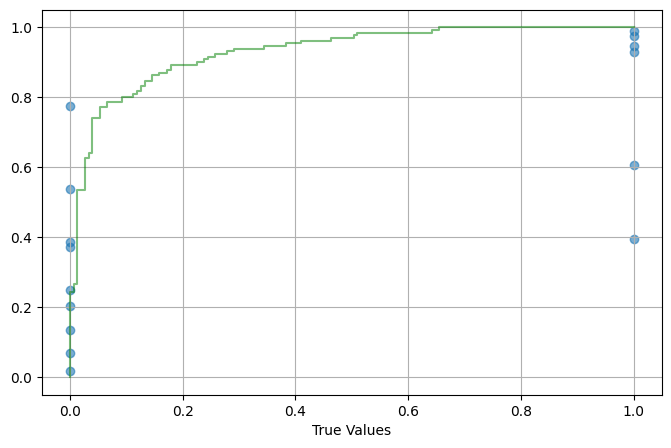

In [66]:
test = torch.sigmoid(model(test_inputs))
accuracy_test = (test > 0.5).float().mean()
print(accuracy_test)

with torch.no_grad():
    test_outputs3 = model(test_inputs)
    test_preds = torch.sigmoid(test_outputs3)
    predicted_classes = (test_preds > 0.5).float()
    test_accuracy3 = (predicted_classes == test_targets).float().mean()
    print(f"Training Accuracy: {test_accuracy3.item()*100:.2f}%")

    # Plot predictions vs. true values
    plt.figure(figsize=(8, 5))
    plt.scatter(test_targets.numpy(), test_preds.numpy(), alpha=0.6)
    plt.xlabel("True Values")

# roc curve
test_fpr3, test_tpr3, _ = roc_curve(targets.numpy(), preds.numpy())
plt.plot(test_fpr3, test_tpr3, label = "ROC Curve", color = "green", alpha=0.5)
plt.grid(True)

## comparison

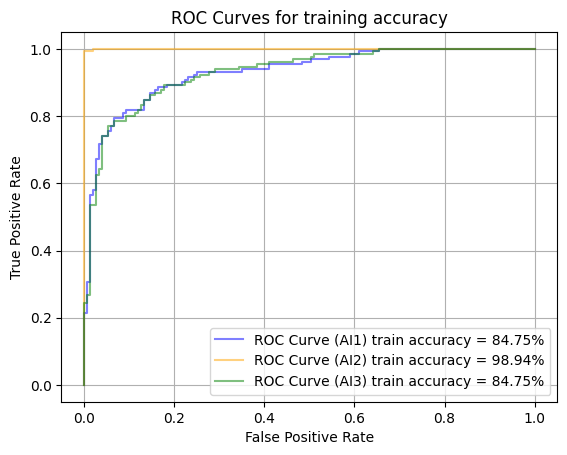

In [67]:
# roc curve
plt.plot(fpr1, tpr1, label = f"ROC Curve (AI1) train accuracy = {accuracy1.item()*100:.2f}%", c="blue", alpha=0.5) #blue
plt.plot(fpr2, tpr2, label = f"ROC Curve (AI2) train accuracy = {accuracy2.item()*100:.2f}%", c="orange", alpha=0.5) #orange
plt.plot(fpr3, tpr3, label = f"ROC Curve (AI3) train accuracy = {accuracy3.item()*100:.2f}%", c="green", alpha=0.5) #green
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for training accuracy")
plt.legend()

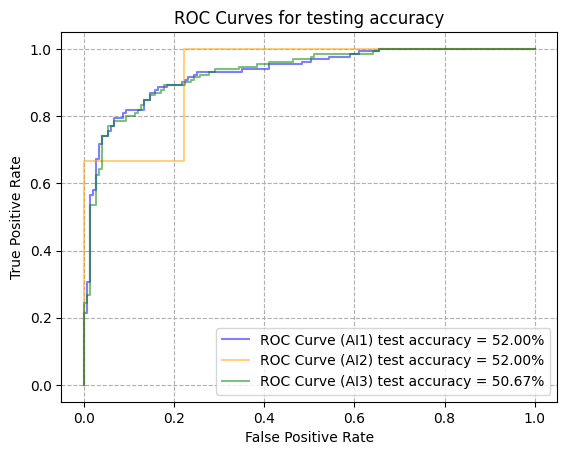

In [68]:
# roc curve
plt.plot(test_fpr1, test_tpr1, label = f"ROC Curve (AI1) test accuracy = {test_accuracy1.item()*100:.2f}%", c="blue", alpha=0.5) #blue
plt.plot(test_fpr2, test_tpr2, label = f"ROC Curve (AI2) test accuracy = {test_accuracy2.item()*100:.2f}%", c="orange", alpha=0.5) #orange
plt.plot(test_fpr3, test_tpr3, label = f"ROC Curve (AI3) test accuracy = {test_accuracy3.item()*100:.2f}%", c="green", alpha=0.5) #green
plt.grid(True, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for testing accuracy")
plt.legend()